In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

# Load and preprocess data

In [2]:
df = pd.read_csv("latestdataset.csv")

# Drop unwanted columns 
df.drop(columns=["rain (mm)", "precipitation (mm)", "soil_moisture_0_to_7cm (m³/m³)"], inplace=True)

# Parse datetime
df['time'] = pd.to_datetime(df['time'])
df = df.set_index('time')

# Convert to float
df = df.astype(float)

In [14]:
df.head()

,temperature_2m (°C),relative_humidity_2m (%),wind_speed_10m (km/h),soil_temperature_0_to_7cm (°C)
time,,,,
2015-01-01 00:00:00,20.2,96.0,6.6,22.2
2015-01-01 01:00:00,20.2,95.0,9.3,22.0
2015-01-01 02:00:00,20.3,96.0,10.5,22.0
2015-01-01 03:00:00,21.1,93.0,8.7,22.4
2015-01-01 04:00:00,22.5,86.0,8.2,23.3


# Scale data

In [3]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df.values)

df_scaled = pd.DataFrame(scaled, index=df.index, columns=df.columns)

# ----------------------
# Create sequences for supervised learning
# ----------------------

In [4]:
def create_sequences(data, lookback=48, horizon=6):
    X, y = [], []
    for i in range(len(data) - lookback - horizon + 1):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback:i+lookback+horizon])  # multi-step target
    return np.array(X), np.array(y)

# Inverse Scaling helper

In [5]:
def inverse_scale_preds(y_scaled, scaler):
    samples, H, F = y_scaled.shape
    y_inv = np.zeros_like(y_scaled)
    for h in range(H):
        y_inv[:, h, :] = scaler.inverse_transform(y_scaled[:, h, :])
    return y_inv

# Data Preparation

In [6]:
lookback = 48
horizon = 6
n_features = df_scaled.shape[1]   # after excluding rain/precipitation/soil moisture

X, y = create_sequences(df_scaled, lookback, horizon)

# Flatten targets for training (Keras Dense expects 2D output)
y_flat = y.reshape((y.shape[0], -1))  # (samples, horizon * n_features)

# Train-test split

In [7]:
# Train/Val/Test split
train_size = int(len(X) * 0.7)
val_size   = int(len(X) * 0.15)

X_train, y_train = X[:train_size], y_flat[:train_size]
X_val,   y_val   = X[train_size:train_size+val_size], y_flat[train_size:train_size+val_size]
X_test,  y_test  = X[train_size+val_size:], y_flat[train_size+val_size:]

# Build GRU model

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

model = Sequential([
    GRU(128, return_sequences=True, input_shape=(lookback, n_features)),
    GRU(128, return_sequences=False),
    Dropout(0.0),
    Dense(128, activation='relu'),
    Dense(horizon * n_features)   # flattened multi-step output
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

C:\Users\krati\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 48, 128)             │          51,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 128)                 │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 24)                  │           3,096 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 170,136 (664.59 KB)

 Trainable params: 170,136 (664.59 KB)

 Non-trainable params: 0 (0.00 B)

# Training

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5),
    ModelCheckpoint("best_gru.keras", save_best_only=True, monitor="val_loss")
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 130s 63ms/step - loss: 0.0116 - mae: 0.0676 - val_loss: 0.0031 - val_mae: 0.0390 - learning_rate: 0.0010
Epoch 2/50
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 122s 63ms/step - loss: 0.0028 - mae: 0.0369 - val_loss: 0.0033 - val_mae: 0.0403 - learning_rate: 0.0010
Epoch 3/50
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 117s 61ms/step - loss: 0.0026 - mae: 0.0355 - val_loss: 0.0029 - val_mae: 0.0381 - learning_rate: 0.0010
Epoch 4/50
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 119s 62ms/step - loss: 0.0024 - mae: 0.0343 - val_loss: 0.0028 - val_mae: 0.0372 - learning_rate: 0.0010
Epoch 5/50
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 113s 59ms/step - loss: 0.0024 - mae: 0.0337 - val_loss: 0.0026 - val_mae: 0.0351 - learning_rate: 0.0010
Epoch 6/50
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 110s 57ms/step - loss: 0.0023 - mae: 0.0330 - val_loss: 0.0026 - val_mae: 0.0345 - learning_rate: 0.0010
Epoch 7/50
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 108s 56ms/step - loss: 0.0023 - mae: 0.0324 - val_loss: 0.0026 - val_mae: 0.

Epoch 55/100
959/959 [==============================] - 66s 69ms/step - loss: 0.0022 - mae: 0.0320 - val_loss: 0.0023 - val_mae: 0.0322 - lr: 1.0000e-05
Epoch 56/100
959/959 [==============================] - 77s 80ms/step - loss: 0.0022 - mae: 0.0320 - val_loss: 0.0023 - val_mae: 0.0322 - lr: 1.0000e-05
Epoch 57/100
959/959 [==============================] - 76s 79ms/step - loss: 0.0022 - mae: 0.0319 - val_loss: 0.0023 - val_mae: 0.0322 - lr: 1.0000e-05
Epoch 58/100
959/959 [==============================] - 73s 76ms/step - loss: 0.0022 - mae: 0.0319 - val_loss: 0.0023 - val_mae: 0.0322 - lr: 1.0000e-05
Epoch 59/100
959/959 [==============================] - 71s 74ms/step - loss: 0.0022 - mae: 0.0319 - val_loss: 0.0023 - val_mae: 0.0322 - lr: 1.0000e-05
Epoch 60/100
959/959 [==============================] - 71s 74ms/step - loss: 0.0022 - mae: 0.0319 - val_loss: 0.0023 - val_mae: 0.0322 - lr: 1.0000e-05
Epoch 61/100
959/959 [==============================] - 88s 92ms/step - loss: 0.00

# Load the saved model

In [9]:
from tensorflow.keras.models import load_model

# load saved model
model = load_model('best_gru.keras')

# Evaluation

In [10]:
# Predictions
y_pred_flat = model.predict(X_test)
y_pred = y_pred_flat.reshape((y_pred_flat.shape[0], horizon, n_features))
y_true = y_test.reshape((y_test.shape[0], horizon, n_features))

# Inverse scaling
y_pred_inv = inverse_scale_preds(y_pred, scaler)
y_true_inv = inverse_scale_preds(y_true, scaler)

411/411 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step


In [11]:
# Metrics (per feature & horizon)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

selected_features = [
    "temperature_2m (°C)",
    "relative_humidity_2m (%)",
    "wind_speed_10m (km/h)",
    "soil_temperature_0_to_7cm (°C)"
]

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# -------------------------------
# Assume:
# y_true_inv.shape = (samples, horizon, n_features)
# y_pred_inv.shape = (samples, horizon, n_features)
# selected_features = ["temperature_2m (°C)", "relative_humidity_2m (%)", 
#                      "wind_speed_10m (km/h)", "soil_temperature_0_to_7cm (°C)"]
# horizon = 6   # (or 1 if you do single-step)
# -------------------------------

results = {}
averages = {}

for f_idx, feature in enumerate(selected_features):
    results[feature] = {}
    mae_list, rmse_list, r2_list = [], [], []
    
    for h in range(horizon):
        y_true_h = y_true_inv[:, h, f_idx]
        y_pred_h = y_pred_inv[:, h, f_idx]

        mae  = mean_absolute_error(y_true_h, y_pred_h)
        rmse = np.sqrt(mean_squared_error(y_true_h, y_pred_h))
        r2   = r2_score(y_true_h, y_pred_h)

        results[feature][f"Horizon_{h+1}"] = {
            "MAE": mae, "RMSE": rmse, "R2": r2
        }

        mae_list.append(mae)
        rmse_list.append(rmse)
        r2_list.append(r2)
    
    # Average across all horizons for this feature
    averages[feature] = {
        "MAE_avg": np.mean(mae_list),
        "RMSE_avg": np.mean(rmse_list),
        "R2_avg": np.mean(r2_list)
    }

# Convert to DataFrames for readability
per_horizon_df = pd.DataFrame.from_dict(
    {(f,h): results[f][h] for f in results for h in results[f]},
    orient="index"
)
avg_df = pd.DataFrame(averages).T

print("===== Metrics per Feature & Horizon =====")
print(per_horizon_df)
print("\n===== Average per Feature =====")
print(avg_df)

===== Metrics per Feature & Horizon =====
                                               MAE      RMSE        R2
temperature_2m (°C)            Horizon_1  0.462087  0.674156  0.973787
                               Horizon_2  0.559859  0.801355  0.962968
                               Horizon_3  0.632150  0.882667  0.955080
                               Horizon_4  0.683537  0.943837  0.948651
                               Horizon_5  0.727310  0.991476  0.943353
                               Horizon_6  0.754200  1.024669  0.939516
relative_humidity_2m (%)       Horizon_1  2.368980  3.512371  0.973541
                               Horizon_2  3.245614  4.580340  0.955003
                               Horizon_3  3.830712  5.297032  0.939822
                               Horizon_4  4.183912  5.750734  0.929077
                               Horizon_5  4.481885  6.106759  0.920033
                               Horizon_6  4.651036  6.343014  0.913737
wind_speed_10m (km/h)          Hori

In [28]:
y_test.shape

(13147, 24)

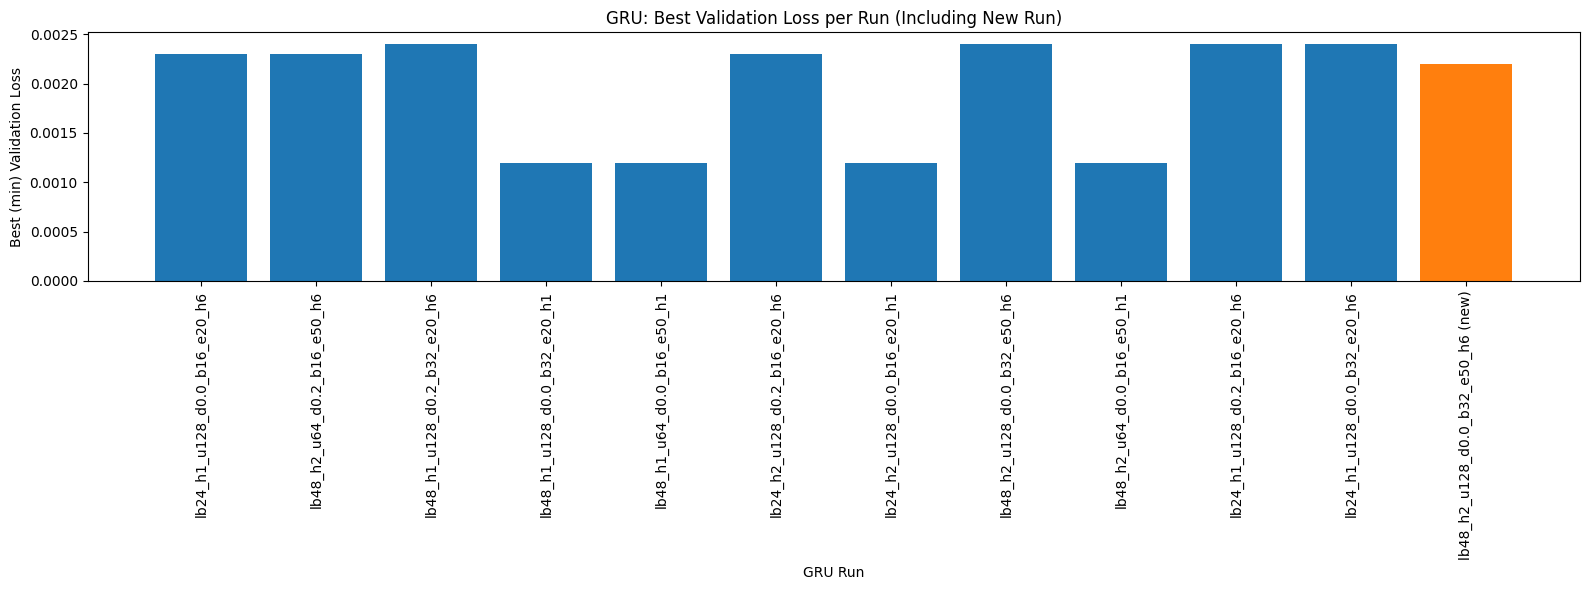

In [29]:
import matplotlib.pyplot as plt

gru_labels = [
    'lb24_h1_u128_d0.0_b16_e20_h6',
    'lb48_h2_u64_d0.2_b16_e50_h6',
    'lb48_h1_u128_d0.2_b32_e20_h6',
    'lb48_h1_u128_d0.0_b32_e20_h1',
    'lb48_h1_u64_d0.0_b16_e50_h1',
    'lb24_h2_u128_d0.2_b16_e20_h6',
    'lb24_h2_u128_d0.0_b16_e20_h1',
    'lb48_h2_u128_d0.0_b32_e50_h6',
    'lb48_h2_u64_d0.0_b16_e50_h1',
    'lb24_h1_u128_d0.2_b16_e20_h6',
    'lb24_h1_u128_d0.0_b32_e20_h6'
]

gru_best_val_loss = [
    0.0023,
    0.0023,
    0.0024,
    0.0012,
    0.0012,
    0.0023,
    0.0012,
    0.0024,
    0.0012,
    0.0024,
    0.0024
]

# Add your new run: label and loss.
gru_labels.append('lb48_h2_u128_d0.0_b32_e50_h6 (new)')  # Append the new run label with your config details
gru_best_val_loss.append(0.0022)                         # Use your best validation loss for the new run

plt.figure(figsize=(16, 6))
plt.bar(gru_labels, gru_best_val_loss, color=['tab:blue']*len(gru_labels[:-1]) + ['tab:orange'])
plt.xlabel('GRU Run')
plt.ylabel('Best (min) Validation Loss')
plt.title('GRU: Best Validation Loss per Run (Including New Run)')
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()


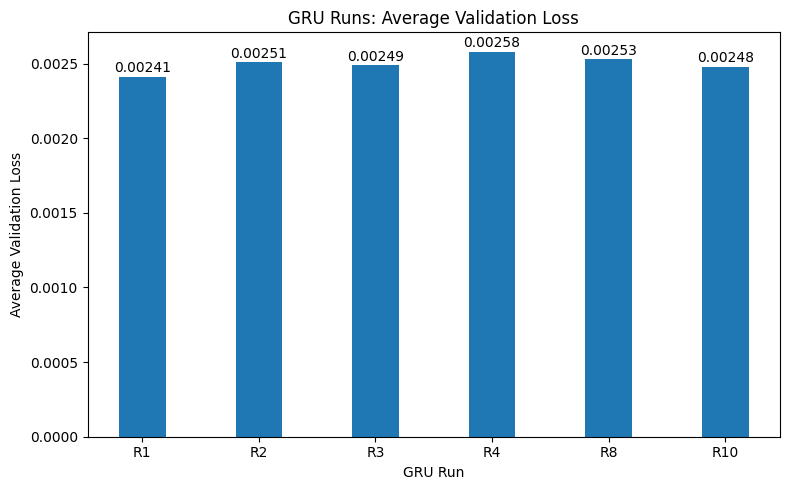

In [30]:
import matplotlib.pyplot as plt#lb48_h1_u128_d0.2_b32_e50_h1

runs = ['R1', 'R2', 'R3', 'R4', 'R8', 'R10']
avg_val_loss = [0.00241, 0.00251, 0.00249, 0.00258, 0.00253, 0.00248]

plt.figure(figsize=(8, 5))
bars = plt.bar(runs, avg_val_loss, color='tab:blue', width=0.4)  # Width controls thickness (smaller = thinner)

plt.xlabel('GRU Run')
plt.ylabel('Average Validation Loss')
plt.title('GRU Runs: Average Validation Loss')

# Annotate numbers on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.00001, f'{yval:.5f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [33]:
# Either (if you already saved after training)
from tensorflow.keras.models import load_model
model = load_model('best_gru.keras')



In [34]:
y_pred_flat = model.predict(X_test)

411/411 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step


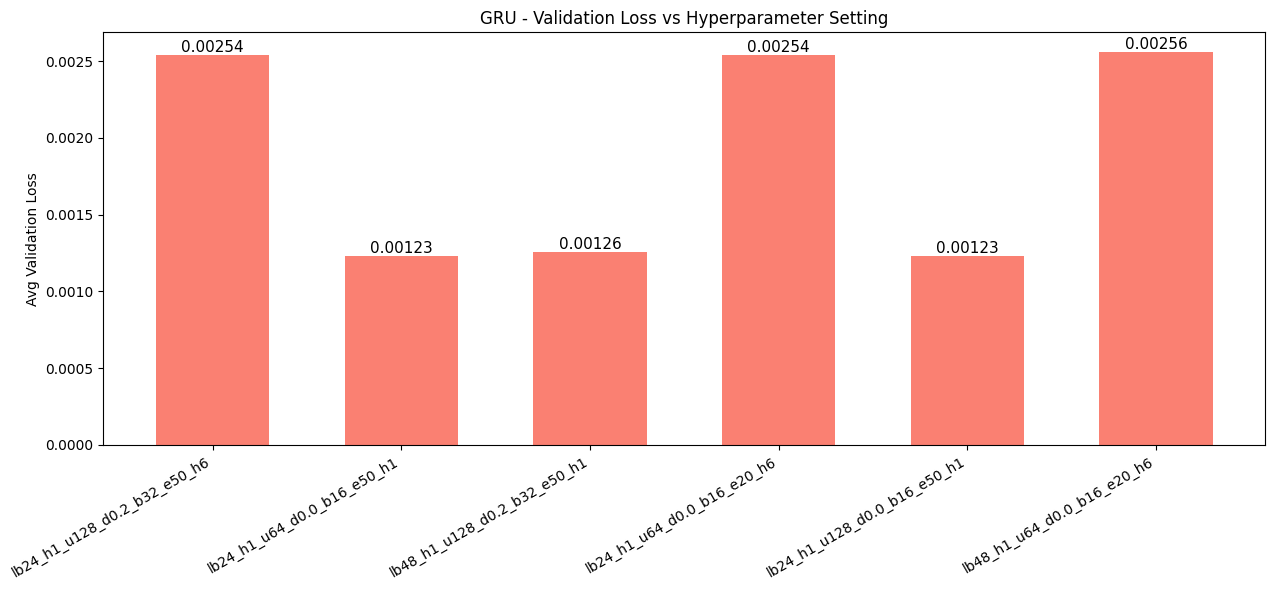

In [1]:
import matplotlib.pyplot as plt

# Remaining GRU runs and their hyperparameters
hyperparams = [
    "lb24_h1_u128_d0.2_b32_e50_h6",   # Run 1 
    "lb24_h1_u64_d0.0_b16_e50_h1",    # Run 2
    "lb48_h1_u128_d0.2_b32_e50_h1",   # Run 3  
    "lb24_h1_u64_d0.0_b16_e20_h6",    # Run 4
    "lb24_h1_u128_d0.0_b16_e50_h1",   # Run 8
    "lb48_h1_u64_d0.0_b16_e20_h6"     # Run 10
]

val_loss = [
    0.00254,  # Run 1
    0.00123,  # Run 2
    0.00126,  # Run 3
    0.00254,  # Run 4
    0.00123,  # Run 8
    0.00256   # Run 10
]

plt.figure(figsize=(13,6))
bars = plt.bar(hyperparams, val_loss, color='salmon', width=0.6)
plt.xticks(rotation=30, ha='right', fontsize=10)
plt.ylabel("Avg Validation Loss")
plt.title("GRU - Validation Loss vs Hyperparameter Setting")
plt.tight_layout()

# Add values on top
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height(),
             f"{bar.get_height():.5f}",
             ha='center', va='bottom', fontsize=11)

plt.show()
